# Processing chain _data science_. 
## _Data wrangling_ avec ‘python’ ([‘scipy’](https://www.scipy.org/), [‘scikit-learn’](https://scikit-learn.org/)) 


|Author|School|Modification| 
|---|---|---| 
|H. Delalin|Arras|2021/02/02| 
|P. Halftermeyer|Orléans|2018/11/17| 

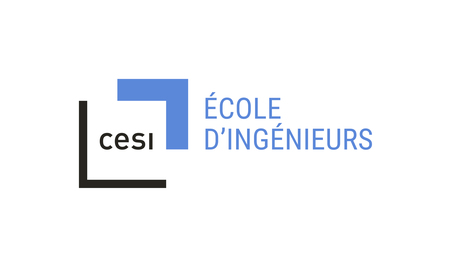

In this notebook, we are going to try to handle a real dataset, from the automated import of files to the preparation of a _ML_ algorithm. 

The _dataset_ presents Californian real estate data. It includes variables such as population, median wage, average house price, etc. And this for each block group (a block group is the smallest administrative division in the United States - between 500 and 5000 people).

### Goals 

The aim is to develop a model for predicting the average price of a property depending on other information. This is clearly a problem [_supervised_](https://en.wikipedia.org/wiki/Supervised_learning) of [_multivariate regression_](https://en.wikipedia.org/wiki/Regression_analysis#General_linear_model).

#### Performance measurement 

It will only come into play in the following notebook, that said, it’s important to have an idea of the goals from the start of project. 

We will eventually focus on the minimization of the [_root mean square error (RMSE)_]((https://en.wikipedia.org/wiki/Root-mean-square_deviation) and/or the [_mean absolute error (MAE)_](https://en.wikipedia.org/wiki/Mean_absolute_error) of our model: 

$$ 
\newcommand\x{\mathbf{x}} 
\newcommand\X{\mathbf{X}} 
\newcommand\y{\mathbf{y}} 
\newcommand\Y{\mathbf{Y}} 
\newcommand\RMSE{\mbox{RMSE}} 
\newcommand\MAE{\mbox{MAE}} 
$$ 
$$ 
\RMSE(\X,h)=\sqrt{\frac{1}{m}\sum_{i=1}^{m}{(h(\x^{(i)})-y^{(i)})^2}} 
$$ 

$$ 
\MAE(\X,h)=\frac{\sum_{i=1}^{m}{\lvert h(\x^{(i)})-y^{(i)})\rvert}}{m} 
$$ 

where $h$ is the function of the model. 

### Preparing the environment 

Below are some imports and precautions prior to our work. It's worth going through them. 
If necessary, create a block at the beginning of the course to install all the necessary libraries by executing the following commands in turn: 
- pip install numpy 
- pip install pandas 
- pip install sklearn

In [167]:
# imports 
import numpy as np 
import os 

from numpy.random import default_rng 
# notebook stability from one run to the next 
random=default_rng(42) 

# pretty pictures directly in the notebook 
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt 
plt.rcParams['axes.labelsize'] = 14 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 

# where to save the pictures 
PROJECT_ROOT_DIR = "." 
CHAPTER_ID = 'workflowDS' 
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID) # the folder must exist 

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300): 
 path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension) 
 print("Saving figure", fig_id) 
 if tight_layout: 
    plt.tight_layout() 
    plt.savefig(path, format=fig_extension, dpi=resolution) 

### Data import 

Data import needs to be automated. We're going to implement a function that takes care of: 
* downloading the archive 
* extracting files 

It's conceivable that a variant of this function could be included in a related ‘python’ module as part of the toolbox of the _data scientist_ that you are. Keep it in your _notebook_ for the exercise.

In [168]:
import os 
import tarfile 
from six.moves import urllib 

DOWNLOAD_ROOT = "https://github.com/ph10r/eiSpeInfoDS/raw/master/" 
HOUSING_PATH = os.path.join("datasets", "housing") 
HOUSING_URL = DOWNLOAD_ROOT + "housing.tgz" 

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH): 
 if not os.path.isdir(housing_path): 
    os.makedirs(housing_path) 
 tgz_path = os.path.join(housing_path, "housing.tgz")
 urllib.request.urlretrieve(housing_url, tgz_path)
 housing_tgz = tarfile.open(tgz_path)
 housing_tgz.extractall(path=housing_path)
 housing_tgz.close()
   

We can now import the data:

In [169]:
fetch_housing_data()

### Loading data into memory 

Similarly, we will create a function using [‘pandas’](https://pandas.pydata.org/) which loads the data into memory into a [‘Pandas DataFrame’](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#pandas.DataFrame).

In [170]:
import pandas as pd 

def load_housing_data(housing_path=HOUSING_PATH): 
 csv_path = os.path.join(housing_path, "housing.csv") 
 return pd.read_csv(csv_path)
 


In [171]:
housing = load_housing_data()

### At a glance 

1. Let's look at the first few lines of our ‘DataFrame’ with the [‘head ()’] method [‘head()’](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html?highlight=head):

In [172]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


2. Now let's use [‘info()’](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html?highlight=info#pandas.DataFrame.info) to get a description of the dataset:

In [173]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


3. The function [‘value_count()’](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html?highlight=value_count) allows you to know, for example, the number of different values of a [‘Series’](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html#pandas.Series) such as ‘ocean_proximity’, which seems to be categorical:

In [174]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

4. The ‘describe ()’ method provides a statistical summary of the numerical values:

In [175]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


5. We can use the function [‘hist()’](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html?highlight=hist#matplotlib.pyplot.hist) and [‘matplotlib’](https://matplotlib.org/) to display a histogram by numerical attribute.

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

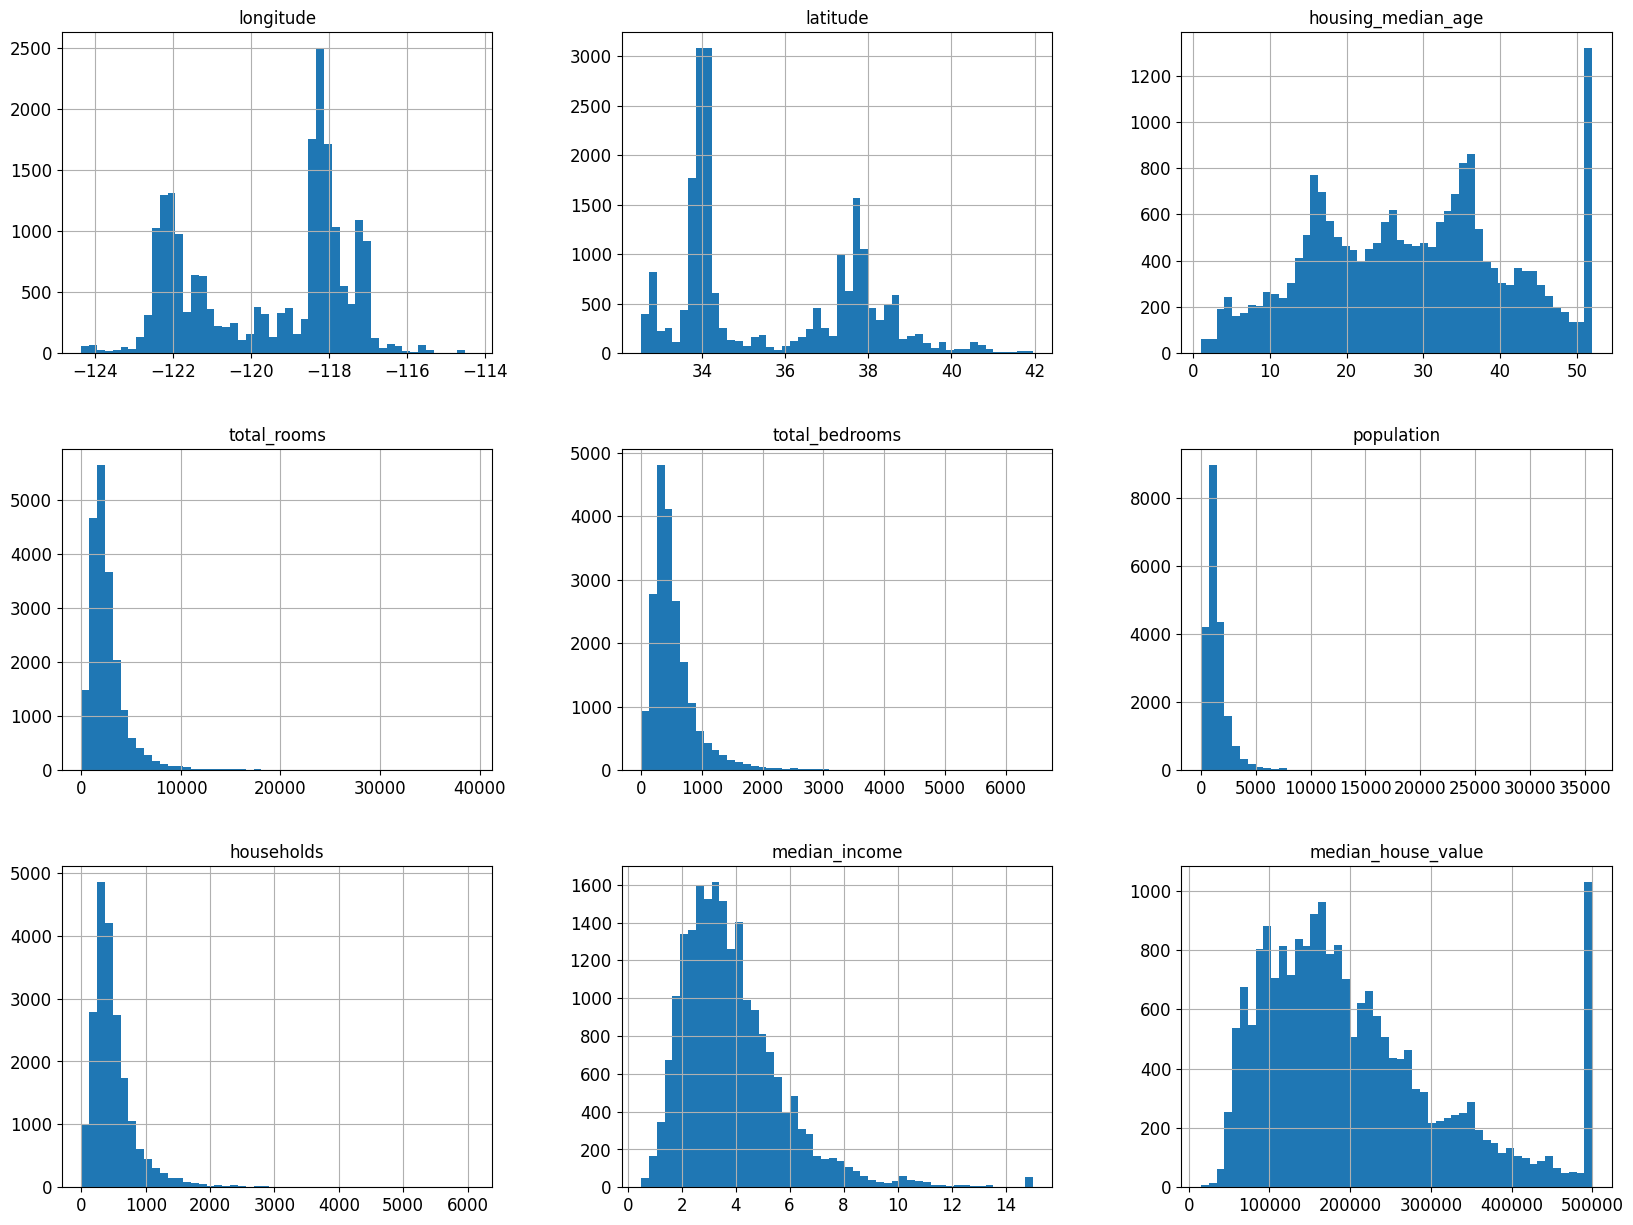

In [176]:
housing.hist(bins=50, figsize=(20,15))


#### Notes: 
* ''median_income'' is not in US dollars (we learn by consulting the authors of the _dataset_ that the values have been scaled and _capped_ between 0.49999 and 15.0001, i.e. all values less than 0.49999 will be recorded at 0.49999 and all values above 15.0001 will be recorded at 15.0001). 
* ‘housing_median_age’ and ‘median_house_value’ are capped as well. This is a problem for the second of these _features_ because it's our target variable. Our model will have to learn to respect this _caping_ and the customer will have to be informed: does this limit suit their needs? If this is not the case, we can try to collect other data or remove the values concerned from the _dataset_. 
* The scales are very different from one _feature_ to another. A _scaling_ will undoubtedly be necessary to obtain a high-performance model. 
* several histograms are _tail heavy_ while the algorithms of _ML_ generally work better with _bell curves_.

### Bad practices described in the text of prosit 
Here's what the prosit actor did: 
- delete variables with missing data 
- remove qualitative variables 
work on the complete dataset, which will not allow you to test the quality of the results obtained (if you want to perform a classification or regression) 

By removing variables, we may lose important information. 

#### Hierarchical Ascending Classification 

Don't be surprised if it takes a while for the results to be displayed... The entire dataset is used and the algorithm is not the most suitable for large datasets. 
Note that the algorithm uses the Euclidian distance to measure the distance between 2 points (block groups at business level) and that the Ward method is used to minimize the distance between points within the same group. 

In [177]:
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import AgglomerativeClustering 

X = housing.copy() # A new copy of data set 
X.drop("ocean_proximity", axis=1, inplace=True) # Not numerical 
X.drop("total_bedrooms", axis=1, inplace=True) # Missing values 
X.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,565.0,259.0,3.8462,342200.0


Construction and display of the resulting dendrogram:

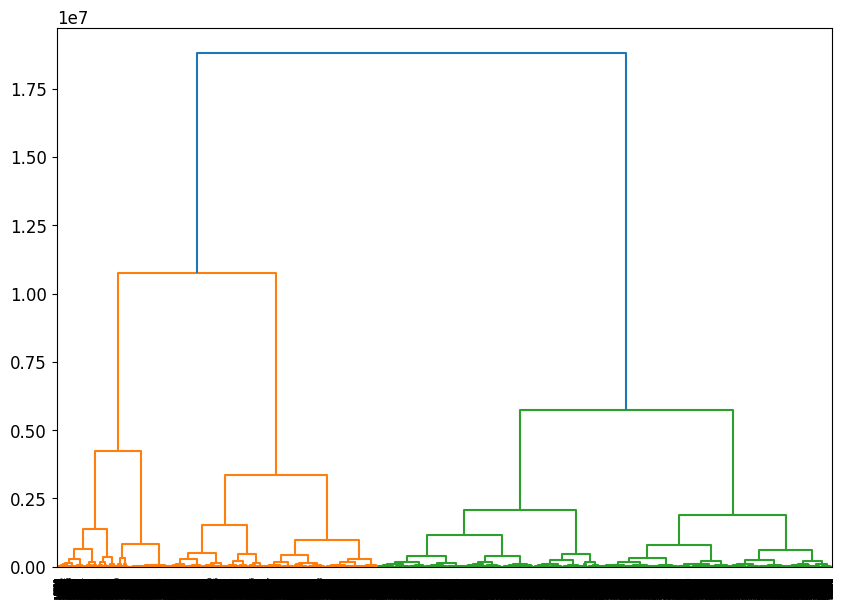

In [178]:
plt.figure(figsize=(10, 7)) 
dendrogram(linkage(X, method='ward'), orientation='top', distance_sort='descending', show_leaf_counts=True) 
plt.show()

Representation as a function of longitude and latitude of the 2 classes (n_clusters) chosen. In relation to the dendrogram, it removes the branches drawn in blue.

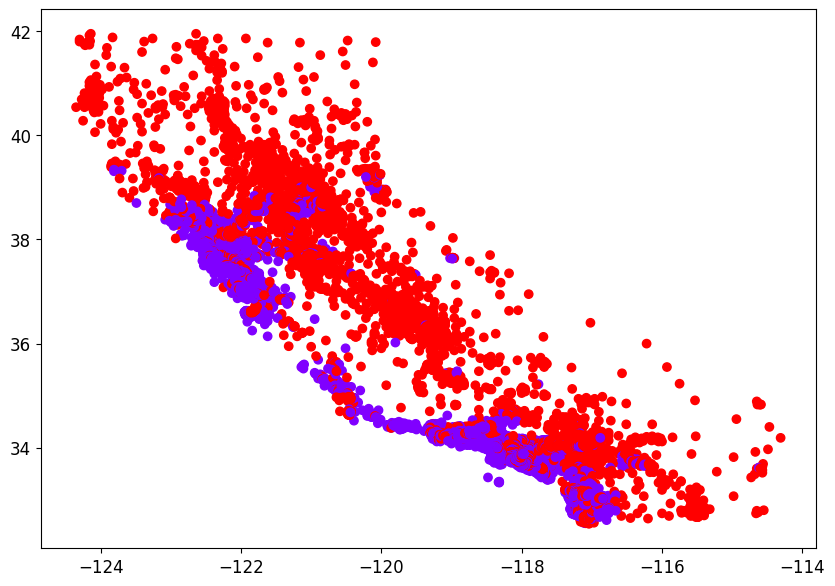

In [179]:
cluster = AgglomerativeClustering(n_clusters=2, linkage='ward') 
cluster.fit_predict(X) 
plt.figure(figsize=(10, 7)) 
plt.scatter(X['longitude'],X['latitude'], c=cluster.labels_, cmap='rainbow') 
plt.show()

### Creating a testing set 

#### Random testing set 
We've already seen too much of this dataset: it's about time we set aside a test sample. In fact, your brain, a remarkable learning machine, is already beginning to establish _patterns_. This could bias the approach leading to the choice of the model and lead to _overlearning_. You should only use the testing set when you are close to the goal and fairly convinced that the model you have established is the right one. Otherwise, we are doing _data snooping_. Note for later: 

&gt; No _data snooping_! 

Creating a testing set is simple: we randomly put 20% of the data aside. 

The example code below illustrates the approach, but the scikit-learn framework contains a function for this purpose. 
We use the [‘numpy.random’](https://numpy.org/doc/stable/reference/random/index.html) to generate a sequence of random bits which is used to generate random numbers. 
In the development phase, to reproduce the same behaviour from one execution of our script to the next, it is customary to manually define a seed for this random sequence. This makes it possible to validate its development without the sequence of random numbers complicating interpretation between two executions. The value classically used for this seed is [42] [42](https://medium.com/@leticia.b/the-story-of-seed-42-874953452b94) (return to the _Preparation of the environment_ part to see). 

In [180]:
import numpy as np 

# For illustration only. Sklearn has train_test_split() 
def split_train_test(data, test_ratio): 
 shuffled_indices = random.permutation(len(data)) 
 test_set_size = int(len(data) * test_ratio) 
 test_indices = shuffled_indices[:test_set_size] 
 train_indices = shuffled_indices[test_set_size:] 
 return data.iloc[train_indices], data.iloc[test_indices]

In [181]:
train_set, test_set = split_train_test(housing, 0.2) 
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In practice, some libraries do not yet use the random bit sequence generators recently introduced in numpy, which may make it more difficult to interpret the behaviour of your script from one run to the next.

#### Using a hashing function 

Below, we define a ‘split_train_test_by_id’ function which builds a testing set by hashing a unique identifier for each line (e.g. the line number). The result of this _hash_ is mapped to the set boolean $\{0,1\}$ respecting the ratio in order to decide the destination of the record (test or training).

In [182]:
from zlib import crc32 

def test_set_check(identifier, test_ratio): 
 return crc32(np.int64(identifier)) &amp; 0xffffffff &lt; test_ratio * 2**32 

def split_train_test_by_id(data, test_ratio, id_column): 
 ids = data[id_column] 
 in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio)) 
 return data.loc[~in_test_set], data.loc[in_test_set]

#### Using ‘SciKit-Learn’ 

The library of _machine learning_ [‘scikit-learn’](https://scikit-learn.org/) provides a function [‘train_test_split’](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform this process. Its use is highly recommended now that we understand how it works.

In [183]:
from sklearn.model_selection import train_test_split

In [184]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [185]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


We must ensure not to introduce statistical bias, on the one hand, and to respect [_stratified sampling_] (https://en.wikipedia.org/wiki/Stratified_sampling). For example, in the case of our example, we will try to have a distribution representative of the ‘median_income’. To avoid under- or over-representation bias, we try to have a limited number of strata (strata that we therefore prefer to be fairly broad).

#### Stratified sampling 

After discussions with business experts, we are convinced that average income is a key variable. We wish to carry out a sampling where the training and test sets respect the proportions of representation of the different salary categories. To do this, we start by creating a variable ‘income_cat’, the categorical counterpart of the numerical variable ‘median_income’

In [186]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5) 
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # replace where false

C:\Users\hp\AppData\Local\Temp\ipykernel_10416\4077767009.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # replace where false


We can see the elements in each category.

<Axes: >

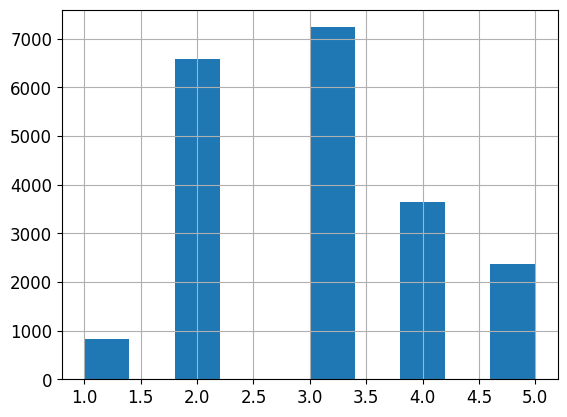

In [187]:
housing["income_cat"].hist()

We can now use [‘StratifiedShuffleSplit’](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) to sample the dataset respecting our constraint:

In [188]:
from sklearn.model_selection import StratifiedShuffleSplit 

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(housing, housing["income_cat"]): 
 print (train_index, test_index) # 1 single loop if n_splits = 1 
 strat_train_set = housing.loc[train_index] 
 strat_test_set = housing.loc[test_index]

[12655 15502  2908 ... 19263 19140 19773] [ 5241 17352  3505 ... 17223 10786  3965]


<Axes: >

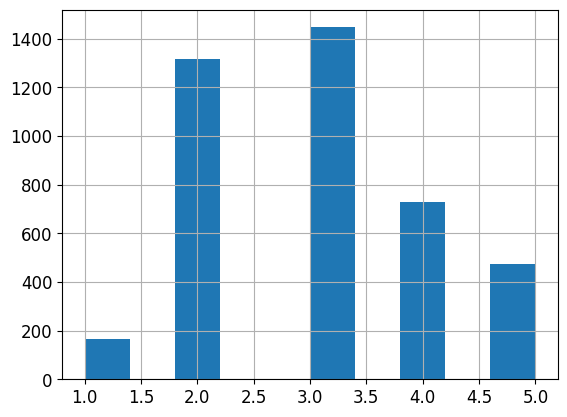

In [189]:
strat_test_set["income_cat"].hist()

Our sampling respects the proportions of the initial set. We no longer need the ‘income_cat’ column: we delete it with [‘drop()’](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html).

In [190]:
for set_ in (strat_train_set, strat_test_set): 
    set_.drop("income_cat", axis=1, inplace=True)
    
 

In [191]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN


Note: If the dataset was larger, we might need to create an exploration set. It's not worth it here.

### Explore the dataset 

With our testing set in place, we can start exploring. We'll be working on a copy of the training set to avoid any nasty surprises.

In [192]:
housing = strat_train_set.copy()

#### Geographic data visualisation 

The library [‘matplotlib’]() can be used to represent data graphically. You can learn how to use it _via_ this [tutorial](https://www.python-course.eu/matplotlib.php). 

Now that we know the geographical coordinates of our records, we want to represent them on the map:

<Axes: xlabel='longitude', ylabel='latitude'>

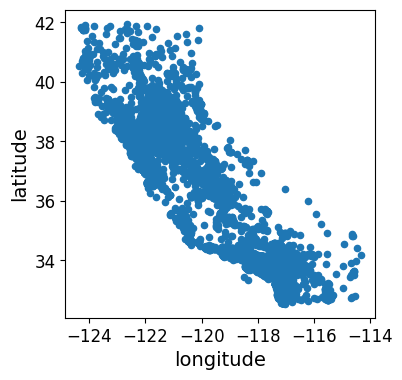

In [193]:
housing.plot(kind="scatter", x="longitude", y="latitude",figsize=(4,4))




It's not very legible, and we'd like to play with the transparency of the points to highlight the point density:

<Axes: xlabel='longitude', ylabel='latitude'>

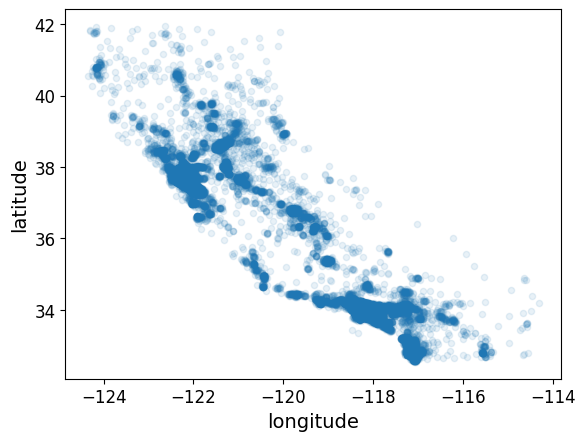

In [194]:
#highlight the point density
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

We can vary the size of our markers (option ‘s’) and their colour (option ‘c’: we use a predefined ‘cmap’ palette called ‘jet’). Here we want to distinguish the zones according to function their population and their average income. 

Saving figure housing_prices_scatterplot


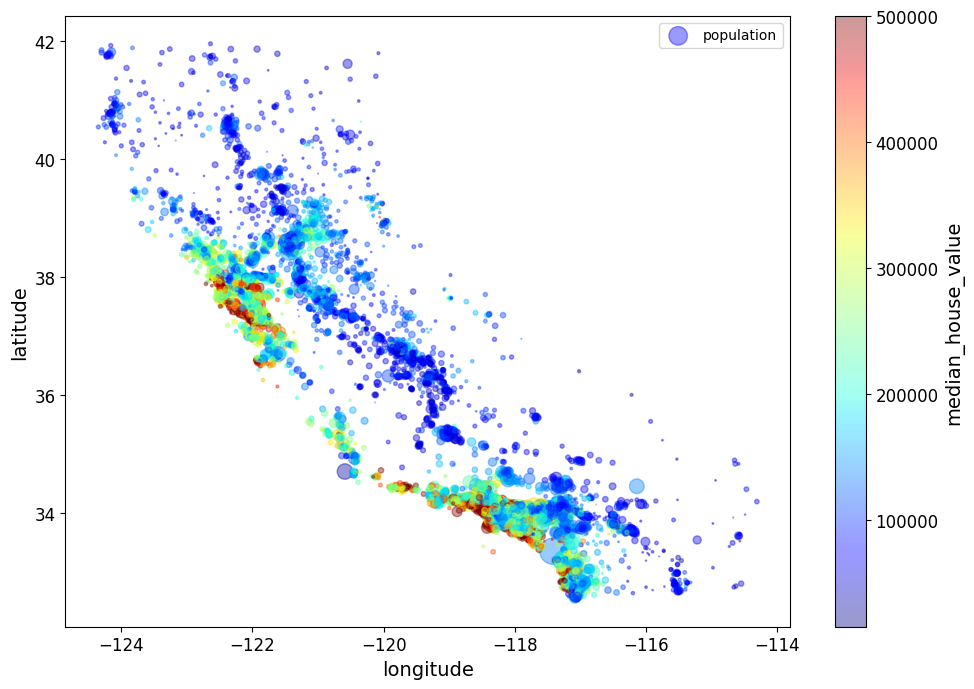

In [195]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
 s=housing["population"]/100, label="population", figsize=(10,7), 
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, 
 sharex=False) 
plt.legend() 
save_fig ("housing_prices_scatterplot") # Will produce an error if directory does not exist

We can see that geographical location matters. We can imagine that the average value of a house is correlated with its proximity to the ocean, on the one hand, and that a _clustering_ algorithm, on the other, would produce interesting results.

If we wanted to view other geographical data. We could use [another palette](https://matplotlib.org/examples/color/colormaps_reference.html) according to what we would like to demonstrate. In the previous example, the colours are on a warm/cool axis; a random palette such as ‘cubehelix’ would have been less easy to interpret. Colour should not be overlooked when it comes to highlighting an idea.

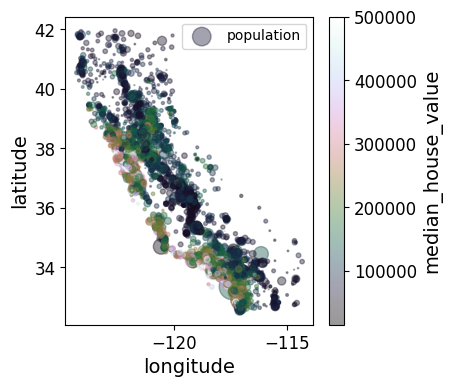

In [196]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
 s=housing["population"]/100, label="population", figsize=(4,4), 
 c="median_house_value", cmap=plt.get_cmap("cubehelix"), colorbar=True, 
 sharex=False) 
plt.legend()

#### Correlation search 

The variables in a dataset may be linked two by two (more or less strongly, positively or negatively), which is why we calculate their [correlation](https://en.wikipedia.org/wiki/Correlation (statistics)).

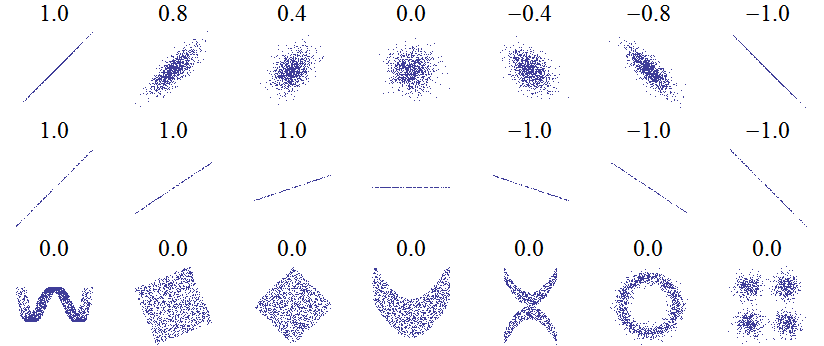

In [148]:
from IPython.display import Image 
Image("https://upload.wikimedia.org/wikipedia/commons/0/02/Correlation_examples.png")

For a small length dataset such as ours, we can calculate the matrix with [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) and display a series, for example that corresponding to the variable ‘median_income’:

In [ ]:
housing.drop("ocean_proximity", axis=1, inplace=True)

corr_matrix = housing.corr()
corr_matrix["median_income"]

longitude            -0.019615
latitude             -0.075146
housing_median_age   -0.111315
total_rooms           0.200133
total_bedrooms       -0.009643
population            0.002421
households            0.010869
median_income         1.000000
median_house_value    0.687151
Name: median_income, dtype: float64

[‘scatter_matrix’](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.plotting.scatter_matrix.html) allows you to view the relationships between variables as well as a _bonus_ histogram for each variable on the diagonal:

Saving figure scatter_matrix_plot


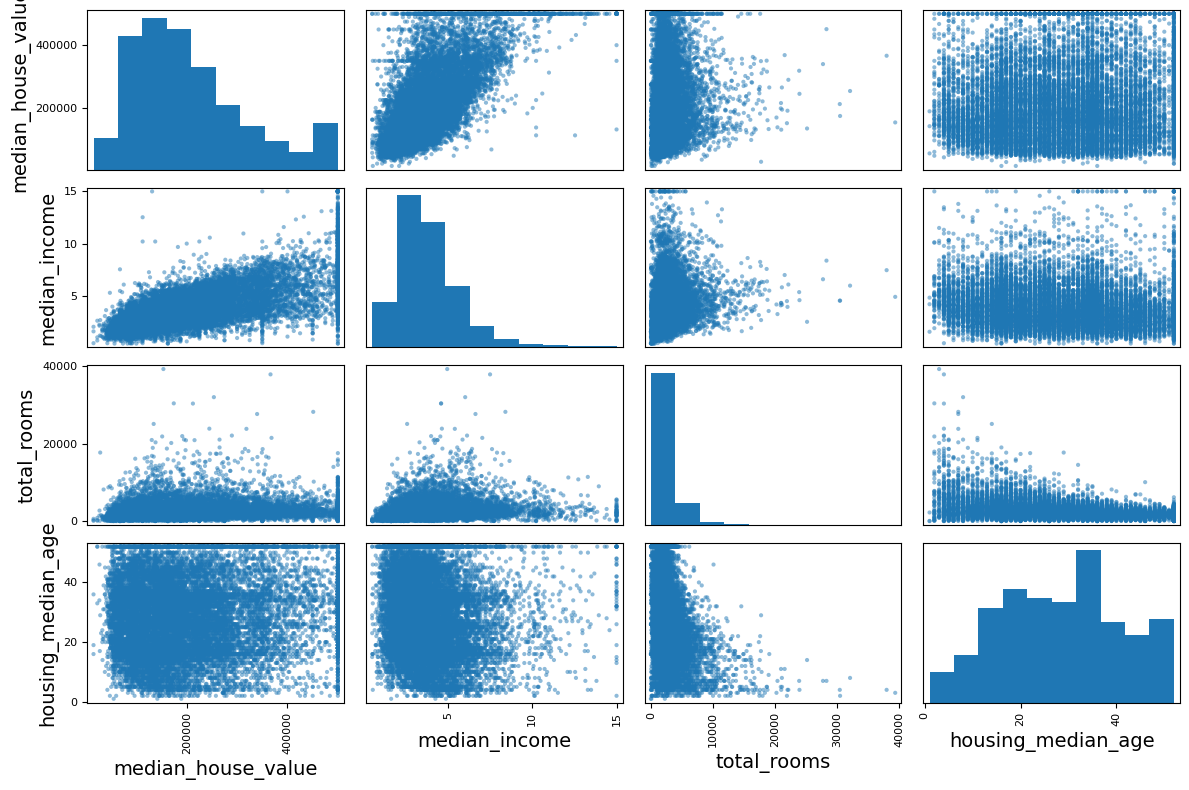

In [202]:
from pandas.plotting import scatter_matrix 

attributes = ["median_house_value", "median_income", "total_rooms", 
 "housing_median_age"] 
scatter_matrix(housing[attributes], figsize=(12, 8)) 
save_fig("scatter_matrix_plot")

We can already see a strong positive correlation between ‘median_income’ and ‘median_house_value’. It's promising. 

Let's zoom in on this candidate:

Saving figure income_vs_house_value_scatterplot


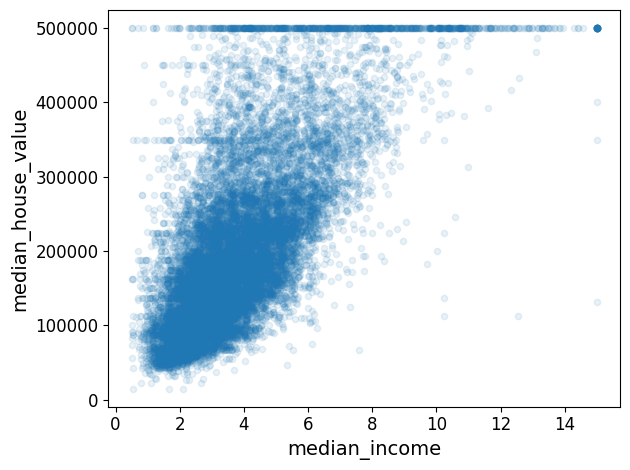

In [203]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", 
 alpha=0.1) 

save_fig("income_vs_house_value_scatterplot")

We can see some areas for improvement: 
- The horizontal lines in the last graph could correspond to the boxes on a questionnaire. It would be legitimate to remove the corresponding values if we wanted to obtain an optimal result. 
Some distributions are _tail-heavy_, we could try to transform them, why not by using a _logarithm_. 
- We also want to combine certain attributes. For example, it seems logical to compare the number of rooms in the district (‘total_rooms’) with the total number of dwellings in the district (‘households’). 

#### Combination of attributes 

As suggested previously, we will create new variables ‘rooms_per_household’, ‘bedrooms_per_room’ and ‘population_per_household’ and view their correlation to ‘median_house_value’.

In [204]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]



In [210]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)



median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

Not bad! There is a fairly strong negative correlation with ‘bedrooms_per_rooms’. 
We're now going to prepare the data for machine learning.

## Data preparation for ML algorithms 

It is essential to script this preparation for several reasons: 
* to make it reproducible, e.g. if you obtain a more recent version of the initial set. 
* To build up a library of utilities. 
* So that these transformations can be used _right away_ in production without human intervention. 
* In order to test several preparation strategies. 

We will start by splitting the dataset. On the one hand, the target variables, or labels, often denoted $\Y$ (only one here therefore $\y$) and on the other hand, the other variables denoted $\X$. We will get ‘housing_labels’ and ‘housing’.

In [211]:
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

#### Data cleaning 

##### Missing values in ‘total_bedrooms’ 

We noticed above, by calling the ‘info()’ method, that the _feature_ ‘total_bedrooms’ had missing values.

In [215]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


We have several options in case of a missing value: 
1. Delete instance 
1. Remove _feature_ 
1. Replace with a value (0, median, _etc_.) 

We could use [‘dropna()’](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna), [‘drop()’](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html#pandas.DataFrame.drop), [‘fillna()’](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna)

In [156]:
# option 1: 
# housing.dropna(subset=["total_bedrooms"]) 
# option 2: 
# housing.drop("total_bedrooms", axis=1) 
# option 3: 
# median = housing["total_bedrooms"].median() 
# housing["total_bedrooms"].fillna(median, inplace=True)

We test these options on the concerned sample ‘sample_incomplete_rows’.

In [157]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head() 
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [158]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"]) # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [159]:
sample_incomplete_rows.drop("total_bedrooms", axis=1) # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [222]:
median = housing["total_bedrooms"].median() 
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3 
sample_incomplete_rows

C:\Users\hp\AppData\Local\Temp\ipykernel_10416\3521726351.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


For added convenience, ‘scikit-learn’ offers a class dedicated to this kind of processing: [‘SimpleImputer’](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html).

In [224]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy="median")

Attention: this strategy only applies to numerical variables, so all other variables must be _dropped_ for processing.

In [223]:
#housing_num = housing.drop('ocean_proximity', axis=1) 
# More generally: 
housing_num = housing.select_dtypes(include=[np.number]) 

We can now _train_ the ‘Imputer’ with the ‘fit()’ method.

In [225]:

# We can now _train_ the ‘Imputer’ with the ‘fit()’ method.
imputer.fit(housing_num)

SimpleImputer(strategy='median')

&gt; The ‘scikit_learn’ _API_ is such that the objects, whether they are _estimators_, _transformers_ or predictors, have a common intuitive syntax. To learn more, it’s recommendable to read _API_ design for machine learning software: experiences from the scikit-learn project_ [Buitinck _et al._](https://hal.inria.fr/hal-00856511/file/paper.pdf).

The ‘Imputer’ calculated the median for each variable and stored it in its ‘_statistics_’ attribute.

In [226]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [227]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

We can then transform the data with the ‘transform()’ method of ‘Imputer’:

In [228]:
X = imputer.transform(housing_num)

The result is an [‘array’](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.array.html) [‘Numpy’](http://www.numpy.org/). We will make it a ‘DataFrame’ by retrieving the column names in ‘housing_num’.

In [242]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

##### Text attributes and categories 

We are now interested in categorical variables. 

##### Numerical conversion

In [244]:
housing_cat = housing[["ocean_proximity"]] 
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


Since the _ML_ algorithms handle numbers better, we _map_ these categories on numbers with ‘OrdinalEncoder’. We use the ‘fit_transform’ method which links ‘fit’ and ‘transform’ as its name suggests.

In [245]:
from sklearn.preprocessing import OrdinalEncoder 

ordinal_encoder = OrdinalEncoder() 
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) 
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

The ‘encoder’ gives access to the mapping of the categories:

In [246]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

&gt; Attention! Algorithms can consider numerical values such as $1$ and $2$ closer to each other than $1$ and $4$ are. This is _in principle_ not true here if we map the categories trivially to ‘[0,1,2,3,4]’. The function _1-hot encoding_ overcomes this problem. Each category will give rise to a new Boolean variable. 

##### _One-hot encoding_ 

When a variable is not ordinal, this solution will create additional variables in the dataset to represent each of the categories. 
In the case of our dataset, this can be an option or we can use the previous approach by specifying the categories order. For example: 'INLAND' &gt; '&lt;1H OCEAN' &gt; 'NEAR OCEAN' &gt; 'NEAR BAY' &gt; 'ISLAND'. 
Professional expertise can help you make this type of choice, depending on the context.

In [247]:
from sklearn.preprocessing import OneHotEncoder

We use the ‘fit_transform’ method of the [‘OneHotEncoder’](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) which returns a ‘sparse matrix’, a compressed version that can be revealed with the ‘toarray()’ method.

In [262]:
cat_encoder = OneHotEncoder() 
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) 
housing_cat_1hot


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [263]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(16512, 5))

An alternative is to use the encoder's option ‘sparse’ option.

In [251]:
cat_encoder = OneHotEncoder(sparse_output==False) 
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) 
housing_cat_1hot # dense array

NameError: name 'sparse_output' is not defined

We have access to categories _through_ the ‘categories_’ attribute in our encoder.

In [264]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

##### _Ad hoc_ transformations

It will sometimes be necessary to implement our own transformations. Remaining consistent with the ‘sci-kit learn’ _API_ will enable us to create homogeneous treatment _pipelines_. 

As ‘scikit-learn’ is based on _duck typing_, the implementation of a transformer will be that of a class containing these methods: 
- ‘fit()’ (often returning ‘self’) 
- ‘transform()’ 
- ‘fit_transform()’ (obtained easily by adding ‘TransformerMixin’ to the base classes) 

Adding the ‘BaseEstimator’ class to the base classes will later enable automated _hyper-parameters_ tuning. It has the effect of adding the ‘get_params’ and ‘set_params’ methods provided you have a fixed number of parameters in the constructor (we will avoid ‘*args’ and ‘**kwargs’). 

We use the example below to create combined variables:

In [265]:
from sklearn.base import BaseEstimator, TransformerMixin 

# index for each column 
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6 

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): 
 def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs 
    self.add_bedrooms_per_room = add_bedrooms_per_room 
 def fit(self, X, y=None): 
    return self # nothing else to do 
 def transform(self, X, y=None): 
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix] 
    population_per_household = X[:, population_ix] / X[:, household_ix] 
    
    print(X[:, rooms_ix],X[:, household_ix],rooms_per_household," ---")
    
    if self.add_bedrooms_per_room: 
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room] 
    else: 
     return np.c_[X, rooms_per_household, population_per_household]

&gt; Note: here our _transformer_ has a unique hyper- parameter ‘add_bedrooms_per_room’. It will be easy to modify our processing chain to find out whether or not this parameter should be added. The parameters make it possible to delay or even automate decision-making of this kind.

In [266]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) 
housing_extra_attribs = attr_adder.transform(housing.values)

[3873.0 5320.0 1618.0 ... 707.0 3155.0 1079.0] [706.0 768.0 300.0 ... 172.0 501.0 197.0] [5.485835694050992 6.927083333333333 5.3933333333333335 ...
 4.1104651162790695 6.297405189620759 5.477157360406092]  ---


In [267]:
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], shape=(16512, 11), dtype=object)

We can rebuild a ‘DataFrame’ with headers.

In [269]:
housing_extra_attribs = pd.DataFrame( 
 housing_extra_attribs, 
 columns=list(housing.columns)+["rooms_per_household", "population_per_household"]) 
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
4,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


##### _Feature scaling_

ML algorithms don’t work well when the _features_ have very different scales (e.g.''number_of_rooms''between 0 and 40000 while''median_income' between 0 and 15). Strategies to address this are: _min-max scaling_ and _standardization_. 
* min-max scaling : _mappe_ [min,max] sur[0,1] ([‘MinMaxScaler’](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)) 
* standardization : _mappe_ la moyenne sur zero avec variance unitaire. ([‘StandardScaler’](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) 

The second option is less sensitive to [_outliers_](https://en.wikipedia.org/wiki/Outlier). 


&gt; Its according to the data from the training set (only) that we will carry out the scaling.

##### Transformation _pipeline_ 

We want to be able to create a _transformer_ which would be the result of all the others (performed in the right order). For example, for numerical attributes:

In [270]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 

num_pipeline = Pipeline([ 
 ('imputer', SimpleImputer(strategy="median")), 
 ('attribs_adder', CombinedAttributesAdder()), 
 ('std_scaler', StandardScaler()), 
 ]) 

housing_num_tr = num_pipeline.fit_transform(housing_num)

[3873. 5320. 1618. ...  707. 3155. 1079.] [706. 768. 300. ... 172. 501. 197.] [5.48583569 6.92708333 5.39333333 ... 4.11046512 6.29740519 5.47715736]  ---


It would be even better if you didn't have to manually extract the numerical values. We would like to be able to feed the _pipeline_ directly with the initial ‘DataFrame’. We''ll use [‘ColumnTransformer’](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to create the branch.

In [271]:
from sklearn.compose import ColumnTransformer

In [272]:
num_attribs = list(housing_num) 
cat_attribs = ["ocean_proximity"] 

full_pipeline = ColumnTransformer([ 
 ("num", num_pipeline, num_attribs), 
 ("cat", OneHotEncoder(), cat_attribs), 
 ]) 

housing_prepared = full_pipeline.fit_transform(housing)

[3873. 5320. 1618. ...  707. 3155. 1079.] [706. 768. 300. ... 172. 501. 197.] [5.48583569 6.92708333 5.39333333 ... 4.11046512 6.29740519 5.47715736]  ---


In [273]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]], shape=(16512, 16))

In [274]:
housing_prepared.shape

(16512, 16)

We are done with the data preparation stage. So define your pipeline to prepare your data so that it as suitable as possible for the execution of the K-Means algorithm. Then you can move on to learning!